# Initial analysis of responses

- number of participants and sessions per script
- participants’ background (linguistics, reading skills, design skills, ...)
- density of the data when compared to all possible combinations (pairs, triplets)
- response frequencies
- compact version of the response data
- binning triplets based on response frequencies for the most popular response
- triplet responses
- similarity matrices
- occurence matrices
- character distinctiveness measures
- comparison between different groups of participants depending on their design skills and nativity/fluency (Cohen kappa)


In [14]:
# intro, defaults (shared across notebooks)

from __future__ import division, print_function

import io
import os
import sys

import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as st
from pandas import DataFrame, Series, MultiIndex
import matplotlib.pyplot as plt
import drawBot as db
from IPython.display import Image
%matplotlib inline


# ---------------------------------------------------
# helpers

def fix_columns(cols):
    for col in cols:
        if col[0] == "control":
            yield col
        else:
            col = list(col)
            col[-1] = tuple(eval(col[-1]))
            yield tuple(col)

def make_compact(d):
    """
    Make DataFrame compact = use [0, 1, 2]
    instead of all characters on the index
    """

    d_compact = pd.DataFrame(columns=d.columns, index=[0, 1, 2])
    for col in d.columns:
        triplet = col[-1] # last item in the index is a triplet
        col_data = pd.Series(d[col].dropna(), index=triplet)
        d_compact[col] = list(col_data) # past regardless the index
    d = d_compact.fillna(0)
    return d


# ---------------------------------------------------
# set global properties for plotting

font = {"family":"Adapter Mono PE", "size":"10", "weight":"medium"}
figure = {"titlesize":"10","titleweight":"medium"}
axes = {"titlesize":"10", "titleweight":"medium", "labelsize":"10", "labelweight":"medium"}
plt.rc("font", **font)
plt.rc("figure", **figure)
plt.rc("axes", **axes)
box_colors = dict(boxes="Black", whiskers="0.5", medians="Black", caps="0.5")

In [15]:
# Get data

d = pd.read_csv("csv/raw-data-preprocessed.csv", index_col=0, header=[0,1,2], dtype="unicode")
d.sort_index(axis=1, inplace=True)
non_control_columns = [col for col in d.columns if col[0] != "control"]

# fix type
d["control", "control", "order"] = d["control", "control", "order"].astype("float").astype("int")

# fix triplet columns (convert them to tuples)
d.columns = pd.MultiIndex.from_tuples(list(fix_columns(d.columns)))

# data frame just for the demographics
demo = d["control", "control"]

print("Imported %d rows, %d columns." % d.shape)


# ---------------------------------------------------
# lists of typefaces and scripts

from chardict import chardict, all_characters, all_typefaces, all_script_typefaces

sorted_scripts = sorted(all_script_typefaces.keys())
# get sorting for all characters in all scripts together
sorted_chars = []
for script in ["cyrillic", "devanagari", "latin"]:
    sorted_chars += list(chardict[script].keys())

Imported 1787 rows, 1579 columns.


In [3]:
# overview of the participants and triplet trials

print("Participants: %s, studies: %s" % (len(demo[demo["order"] == 1]), len(demo)))
print("Triplet responses: %s" % len(demo)*56)

# participants for each script for all (1) and combined studies (2)
gdata = demo["order"].groupby([demo["script"], demo["order"]])
print(gdata.count())

# participants for each typeface for all (1) and combined studies (2)
gdata = demo["order"].groupby([demo["script"], demo["typeface"], demo["order"]])
print(gdata.count())

Participants: 1721, studies: 1787
Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787Triplet responses: 1787

In [16]:
# overview of the languages

from collections import OrderedDict

native_l = set((",".join(list(demo["native languages"]))).split(","))
fluent_l = set((",".join(list(demo["fluent languages"]))).split(","))
print("Reported %s languages of which %s are native of which %s are fluent" % (len(fluent_l|native_l), len(native_l), len(fluent_l)))

# report how many are native & fluent languages
for script in sorted_scripts:
    dl = demo[(demo["script"] == script) & (demo["order"] == 1)]
    participants = len(dl)
    native_l = set((",".join(list(dl["native languages"]))).split(","))
    fluent_l = set((",".join(list(dl["fluent languages"]))).split(","))
    counts_l = OrderedDict()
    for l in native_l|fluent_l:
        counts_l[l] = (len(dl[dl["native languages"].str.contains(l)]),
                        len(dl[dl["fluent languages"].str.contains(l)]))
        
    for mode in [0, 1]:
        print()
        print(script.upper(), ["native", "fluent"][mode])
        print()
        other = 0
        for i, (k, v) in enumerate(sorted(counts_l.items(), key=lambda x: x[1][mode], reverse=True)):
            if i < 5:
                print("%s (%d), " % (k.title(), v[mode]), end="")
            else:
                other += v[mode]
        print("other (%d)" % other)
print()
del dl

# group data/participants by script nativity & fluency
dl = demo[demo["order"]==1]
gdata = dl["order"].groupby([dl["script"], dl["native in script"]])
print(gdata.count())
gdata = dl["order"].groupby([dl["script"], dl["fluent in script"]])
print(gdata.count())
del gdata
del dl

Reported 96 languages of which 79 are native of which 88 are fluent

CYRILLIC native

Russian (426), Ukrainian (83), Belarusian (27), English (20), Bulgarian (6), other (33)

CYRILLIC fluent

Russian (456), English (323), Ukrainian (143), Belarusian (48), German (29), other (139)

DEVANAGARI native

Hindi (178), English (62), Marathi (56), Tamil (31), Telugu (22), other (156)

DEVANAGARI fluent

English (408), Hindi (337), Marathi (77), Gujarati (35), Sanskrit (29), other (254)

LATIN native

English (322), German (122), Dutch (79), French (55), Czech (49), other (213)

LATIN fluent

English (747), German (175), French (141), Dutch (90), Spanish (84), other (355)

script      native in script
cyrillic    False                37
            True                472
devanagari  False               173
            True                259
latin       False                36
            True                744
Name: order, dtype: int64
script      fluent in script
cyrillic    False          

/var/folders/y9/cdnw18g5777bz8cqsp6zgd380000gn/T/ipykernel_29362/2372134180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dll.rename(columns={"script":"Script"}, inplace=True)


age                Script    
18–30 years        Cyrillic      322
                   Latin         301
31–40 years        Latin         281
                   Devanagari    150
18–30 years        Devanagari    136
41–50 years        Latin         122
31–40 years        Cyrillic      103
41–50 years        Devanagari     89
51–60 years        Latin          48
41–50 years        Cyrillic       47
51–60 years        Devanagari     40
                   Cyrillic       25
61–70 years        Latin          24
                   Devanagari     15
                   Cyrillic        9
71–80 years        Latin           3
                   Cyrillic        2
                   Devanagari      2
81 and more years  Cyrillic        1
                   Latin           1
Name: count, dtype: int64


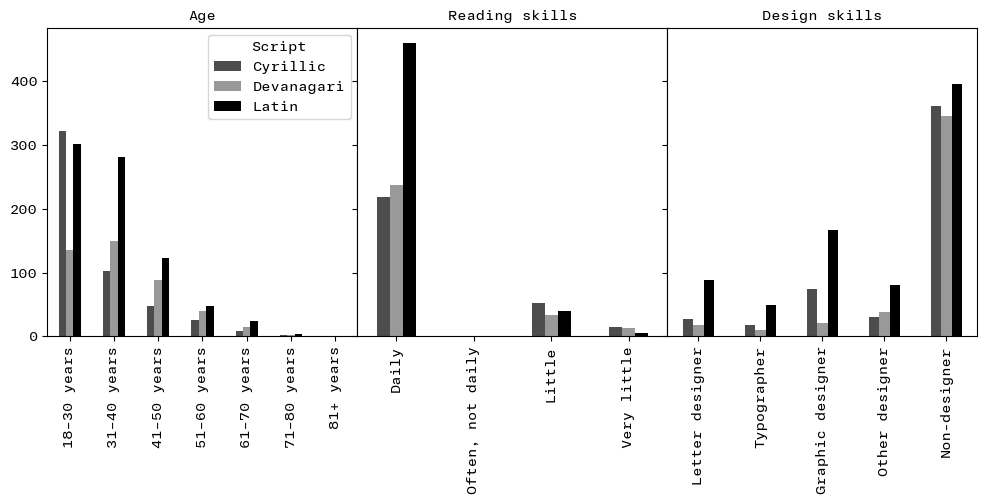

In [17]:
# plot background info collectively

dll = demo[demo["order"] == 1]
dll.loc[:,"script"] = dll["script"].str.title()
dll.rename(columns={"script":"Script"}, inplace=True)
colors = {"Cyrillic": (0.3,0.3,0.3), "Devanagari": (0.6,0.6,0.6), "Latin": (0,0,0)}
fig0, axes0 = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig0.subplots_adjust(wspace=0, hspace=0)

# predefined indexes
age_index = ["18–30 years", "31–40 years", "41–50 years", "51–60 years", "61–70 years", "71–80 years", "81+ years"]
reading_skills_index = ["Daily", "Often, not daily", "Little", "Very little"]
design_skills_index = ["Letter designer", "Typographer", "Graphic designer", "Other designer", "Non-designer"]

# plot
age = dll[["age", "Script"]].value_counts()
print(age)
age.unstack(level=1).reindex(age_index).plot.bar(color=colors, ax=axes0[0], title="Age", xlabel="")
reading_skills = dll[["reading skills", "Script"]].value_counts()
reading_skills.unstack(level=1).reindex(reading_skills_index).plot.bar(color=colors, ax=axes0[1], title="Reading skills", legend=False, xlabel="")

design_skills = dll[["design skills", "Script"]].value_counts()
design_skills.unstack(level=1).reindex(design_skills_index).plot.bar(color=colors, ax=axes0[2], title="Design skills", legend=False, xlabel="")

# save plots
fig0.savefig("graphics/background_overview.pdf", bbox_inches="tight")

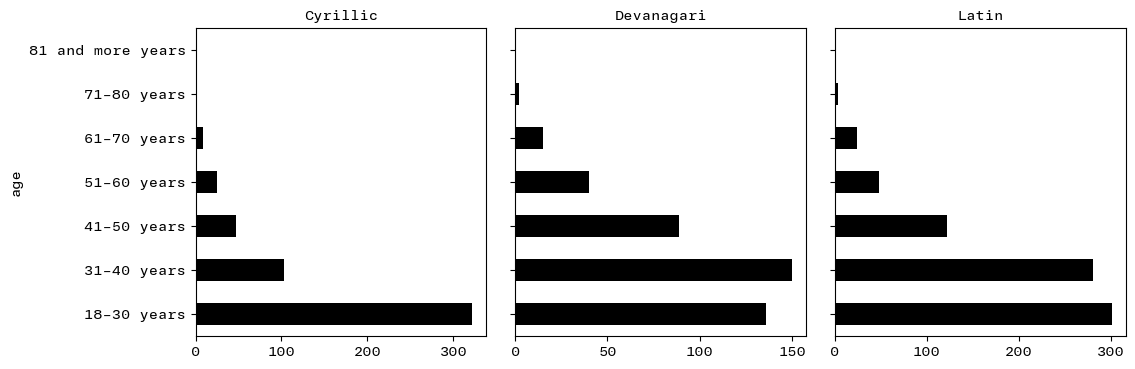

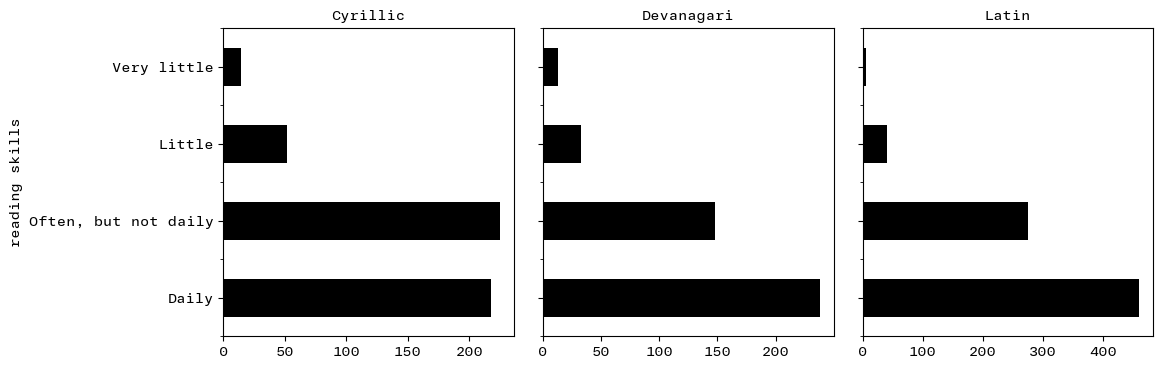

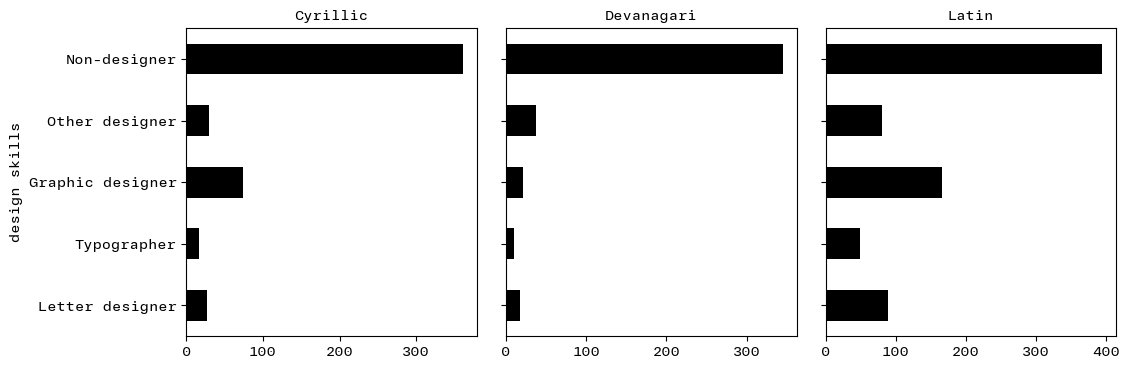

In [18]:
# plot background info per script

dll = demo[demo["order"] == 1]
fig1, axes1 = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig2, axes2 = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig3, axes3 = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig1.subplots_adjust(wspace=0.1, hspace=0.1)
fig2.subplots_adjust(wspace=0.1, hspace=0.1)
fig3.subplots_adjust(wspace=0.1, hspace=0.1)

# predefined indexes
age_index = ["18–30 years", "31–40 years", "41–50 years", "51–60 years", "61–70 years", "71–80 years", "81 and more years"]
reading_skills_index = ["Daily", "Often, but not daily", "Little", "Very little"]
design_skills_index = ["Letter designer", "Typographer", "Graphic designer", "Other designer", "Non-designer"]

# plot
for i, script in enumerate(["cyrillic", "devanagari", "latin"]):
    dl = dll[dll["script"] == script]
    
    age = dl["age"].value_counts().reindex(age_index)
    age.plot(kind="barh", ax=axes1[i], color=(0,0,0), title=script.title())
    reading_skills = dl["reading skills"].value_counts().reindex(reading_skills_index)
    reading_skills.plot(kind="barh", ax=axes2[i], color=(0,0,0), title=script.title())
    design_skills = dl["design skills"].value_counts().reindex(design_skills_index)
    design_skills.plot(kind="barh", ax=axes3[i], color=(0,0,0), title=script.title())

# save plots
fig1.savefig("graphics/background_age.pdf", bbox_inches="tight")
fig2.savefig("graphics/background_reading-skills.pdf", bbox_inches="tight")
fig3.savefig("graphics/background_design-skills.pdf", bbox_inches="tight")

In [19]:
# report the density of the triplet and pairs data compared to all possible combinations

for script in ["cyrillic", "devanagari", "latin"]:
    dt = d[script].dropna(how="all")
    dt.columns = dt.columns.remove_unused_levels()

    # set up lists of all typefaces, triplets, pairs, and characters
    # and corresponding counters
    triplet_counts = {}
    pair_counts = {}
    character_counts = {}
    all_pairs = []
    all_characters = []
    
    # count in the data, always focus on one typeface only
    for typeface, triplet in dt.columns:
        t1, t2, t3 = triplet
        # no need to sort, triplets are already sorted
        if triplet in triplet_counts:
            triplet_counts[triplet] += 1
        else:
            triplet_counts[triplet] = 1
        for p in [[t1,t2], [t2,t3], [t1,t3]]:
            pair = "('%s','%s')" % tuple(sorted(p))
            if pair in pair_counts:
                pair_counts[pair] += 1
            else:
                pair_counts[pair] = 1
                all_pairs.append(pair)
        for char in [t1, t2, t3]:
            if char in character_counts:
                character_counts[char] += 1
            else:
                character_counts[char] = 1
                all_characters.append(char)
    all_characters.sort()
    all_pairs.sort()
    character_count = len(all_characters)
    triplet_combinations_count = float(character_count*(character_count-1)*(character_count-2))/6
    triplet_percentage = round(100*(len(triplet_counts)/triplet_combinations_count), 2)
    pair_combinations_count = float(character_count*(character_count-1))/2
    pair_percentage = round(100*(len(pair_counts)/pair_combinations_count), 2)
    
    # report
    print()
    print(script.upper())
    print("Triplets (ST and ST+TT):", len(triplet_counts), sum(triplet_counts.values()))
    print("Pairs:", len(pair_counts))
    print("Characters (%d):" % len(all_characters), len(character_counts))
    print("%f %% of all %d triplet combinations" % (triplet_percentage, triplet_combinations_count))
    print("%f %% of all %d pair combinations" % (pair_percentage, pair_combinations_count))

# tidy up
del dt


CYRILLIC
Triplets (ST and ST+TT): 446 448
Pairs: 210
Characters (33): 33
8.170000 % of all 5456 triplet combinations
39.770000 % of all 528 pair combinations

DEVANAGARI
Triplets (ST and ST+TT): 443 448
Pairs: 209
Characters (37): 37
5.700000 % of all 7770 triplet combinations
31.380000 % of all 666 pair combinations

LATIN
Triplets (ST and ST+TT): 457 672
Pairs: 196
Characters (26): 26
17.580000 % of all 2600 triplet combinations
60.310000 % of all 325 pair combinations


,0.0,0.25,0.5,0.75,1.0,std,mean,sem,CI,p_val,is_normal
Cyrillic,0.35,0.57,0.69,0.82,0.99,0.15,0.69,0.007,"(0.68, 0.71)",0.0,False
Devanagari,0.34,0.50,0.61,0.74,0.94,0.15,0.62,0.007,"(0.61, 0.64)",0.0,False
Latin,0.34,0.57,0.74,0.87,1.00,0.18,0.72,0.007,"(0.7, 0.73)",0.0,False
All,0.34,0.54,0.68,0.82,1.00,0.17,0.68,0.004,"(0.68, 0.69)",0.0,False


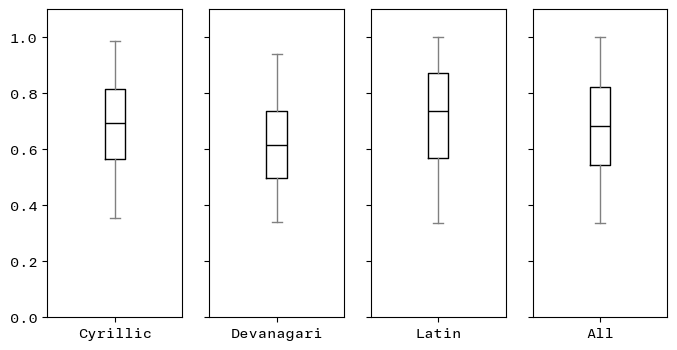

In [20]:
# frequencies & distribution of the most popular response

# functions

def get_frequencies_typeface(d, index=None, mode="relative", sort=False):
    """
    Find relative frequencies for characters in each triplet in DF.
    
    Parameters:
        index: is used to pass a shared index across multiple typefaces
        mode: indicates whether the counts should be normalized (i.e. relative frequencies)
        sort: whether to return a sorted Series instead of matching responses to characters
    Return:
        DF with frequencies.
    """
    
    # the index need to be built first
    # so value_counts below fall to the right slot
    if sort:
        index = [0, 1, 2]
    elif index is None:
        index = []
        for triplet in d.columns:
            index += list(triplet)
        index = sorted(list(set(index)))
    # count frequencies
    frequencies = DataFrame(index=index, columns=d.columns)
    if mode == "relative":
        for triplet in d.columns:
            # get relative frequencies for each character in the triplet
            if sort:
                value_counts = d[triplet].value_counts(dropna=True, normalize=True, ascending=True)
                value_counts.index = index[:len(value_counts)]
            else:
                value_counts = d[triplet].value_counts(dropna=True, normalize=True)
            if not value_counts.empty:
                frequencies[triplet] = value_counts
    elif mode == "absolute":
        for triplet in d.columns:
            # get frequencies for each character in the triplet, do not normalize
            if sort:
                value_counts = d[triplet].value_counts(dropna=True, ascending=True)
                value_counts.index = index[:len(value_counts)]
            else:
                value_counts = d[triplet].value_counts(dropna=True)
            if not value_counts.empty:
                frequencies[triplet] = value_counts
        
    return frequencies

def get_frequencies_script(d, mode="relative", sort=False):
    """
    Find relative frequencies for each typeface in DF.
    
    Parameters:
        mode: indicates whether the counts should be normalized (i.e. relative frequencies)
    Return:
        DF with frequencies.
    """
    
    # the index need to be built first
    # so value_counts below fall to the right slot
    if sort:
        index = [0, 1, 2]
    else:
        index = []
        for triplet in d.columns.levels[1]:
            index += list(triplet)
        index = sorted(list(set(index)))
    frequencies = DataFrame(index=index, columns=d.columns)
    for typeface in d.columns.levels[0]:
        frequencies[typeface] = get_frequencies_typeface(d[typeface], index=index, mode=mode, sort=sort)
        
    return frequencies

def get_frequencies(d_, mode="relative", sort=False):
    """
    Get relative frequencies for all scripts, everything.
    
    Parameters:
        mode: indicates whether the counts should be normalized (i.e. relative frequencies)
    """
    
    d = d_.loc[:,d_.columns.get_level_values(0).isin(["cyrillic", "devanagari", "latin"])]
    d.columns = d.columns.remove_unused_levels()
    d = d.sort_index(axis=1)
    # in case the DF contains multiple scripts, flatten it
    if len(d.columns.levels) > 2:
        backup_cols = d.columns
        dt = d
        dt.columns = dt.columns.droplevel(level=0).unique()
        frequencies = get_frequencies_script(dt, mode=mode, sort=sort)
        frequencies.columns = backup_cols
    else:
        frequencies = get_frequencies_script(d, mode=mode, sort=sort)
    return frequencies


def get_majority(counts):
    """
    Convert probabilities to classification based on majority vote.
    """
    
    majority = pd.DataFrame(0, columns=counts.columns, index=counts.index)
    for col in counts:
        i = counts[col].idxmax()
        majority.loc[i, col] = 1
    return majority

# ---------------------------------------------------------

# obtain frequencies
frequencies = get_frequencies(d).reindex(sorted_chars)
frequencies_counts = get_frequencies(d, mode="absolute").reindex(sorted_chars)
frequencies_max = frequencies.max(skipna=True, axis=0)
frequencies_counts_max = frequencies_counts.max(skipna=True, axis=0)

# save to CSV
if not os.path.exists("csv/frequencies/"):
    os.makedirs("csv/frequencies/")
if not os.path.exists("csv/counts/"):
    os.makedirs("csv/counts/")
frequencies.to_csv("csv/frequencies/frequencies_all.csv")
frequencies_counts.to_csv("csv/counts/counts_all.csv")
frequencies_max.to_csv("csv/frequencies/frequencies_most-popular.csv")
frequencies_counts_max.to_csv("csv/counts/counts_most-popular.csv")

# obtain majority opinion (classification-like)
majority = get_majority(frequencies_counts)

# report & plot multiple box plots next to each other
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(8, 4))
fig.subplots_adjust(wspace=0.2, hspace=0)

report = []
for i, script in enumerate(["cyrillic", "devanagari", "latin", "all"]):
    if script != "all":
        fm = frequencies_max[script]
    else:
        fm = frequencies_max
    fm.name = script.title()
    row = fm.quantile([0.0, .25, .5, .75, 1.0]).round(2)
    # set index to strings to avoid mixing float and str in one index
    row.index = ["0.0", "0.25", "0.5", "0.75", "1.0"]
    mean, sem = fm.mean(), fm.sem()
    row["mean"] = round(mean, 2)
    row["sem"] = round(sem, 3)
    row["std"] = round(fm.std(), 2)
    # confidence interval
    ci = st.t.interval(0.95, len(fm)-1, loc=mean, scale=sem)
    row["CI"] = (round(ci[0], 2), round(ci[1], 2))
    # test the null hypothesis that the frequencies_max come from a normal distribution.
    # It is based on D’Agostino and Pearson’s
    _, p_val = st.normaltest(fm)
    row["p_val"] = round(p_val, 4)
    row["is_normal"] = p_val >= 0.001
    report.append(row)
    # plot
    s_axes = fm.plot(kind="box", ax=axes[i], color=box_colors, title="")
    s_axes.set_ylim([0.0,1.1])

report = DataFrame(report, columns=["0.0", "0.25", "0.5", "0.75", "1.0", "std", "mean", "sem", "CI", "p_val", "is_normal"])
display(report)
    
# save plot
fig.savefig("graphics/frequencies_most-popular_box-plots.pdf", bbox_inches="tight")
report.to_csv("csv/frequencies/frequencies_most-popular_stats.csv", encoding="utf-8")

# tidy up
del fm

In [21]:
# save compact data

fcompact = make_compact(frequencies)
ccompact = make_compact(frequencies_counts)
mcompact = make_compact(majority)
fcompact.to_csv("csv/frequencies/frequencies_compact.csv")
ccompact.to_csv("csv/counts/counts_compact.csv")
mcompact.to_csv("csv/frequencies/frequencies_majority.csv")

Are OOOO frequencies normal?              W          pval  normal
All  69.854739  6.780100e-16   False
Are OOOO frequencies normal?              W          pval  normal
All  90.021601  2.831769e-20   False
Are OOOO frequencies normal?               W          pval  normal
All  284.448512  1.709191e-62   False
Are OOOO frequencies normal?               W           pval  normal
All  466.172639  5.914221e-102   False


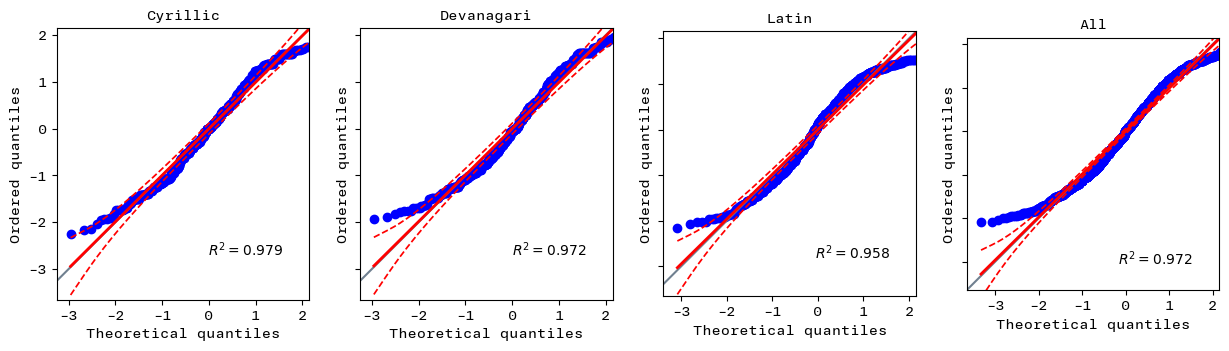

,Cyrillic,Devanagari,Latin,All
All,,,,
"(0.34, 0.5]",16.45,11.83,25.67,13.39
"(0.5, 0.67]",31.89,33.26,36.16,28.12
"(0.67, 0.83]",28.70,32.37,28.35,26.49
"(0.83, 1.0]",22.90,22.54,9.82,31.85


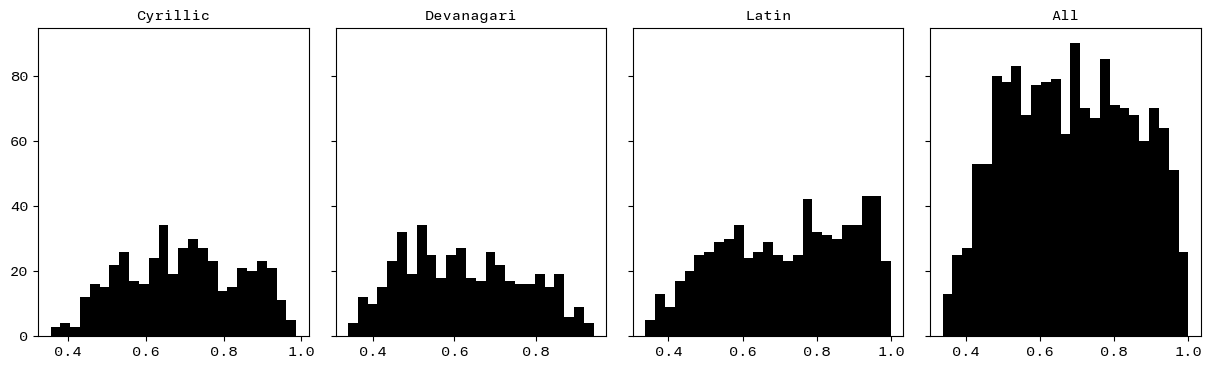

In [29]:
# check for normality and make Q-Q probability plots

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
for i, script in enumerate(["cyrillic", "devanagari", "latin", "all"]):
    if script != "all":
        fm = frequencies_max[script]
    else:
        fm = frequencies_max
    np.random.seed(123)
    x = np.random.normal(size=50)
    pg.qqplot(fm, dist="norm", ax=axes[i])
    axes[i].set_title(script.title())
    print("Are OOOO frequencies normal?", pg.normality(fm, method="normaltest"))
plt.show()
fig.savefig("graphics/frequencies_q-q-plot.pdf")

# make histograms
# bin triplet the most popular response frequencies into 4 bins
# to illustrate the percentage of difficult triplets

report = DataFrame()
fm = frequencies_max.dropna()

# Bin the frequencies into 4 bins...
bins = np.linspace(fm.min(), fm.max(), 5)
groups = fm.groupby(pd.cut(fm, bins, precision=2), observed=False)
# all
report["All"] = (groups.count()*100.0/len(fm)).round(2)
# individual scripts
for script in sorted_scripts:
    groups = fm[script].groupby(pd.cut(fm[script], bins, precision=2), observed=False)
    report[script.title()] = (groups.count()*100.0/len(fm[script])).round(2)
report.columns = sorted(report.columns[1:]) + ["All"]
display(report)
report.to_csv("csv/frequencies/frequencies_most-popular_bands.csv", encoding="utf-8")

# histogram, just because
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,4))
fig.subplots_adjust(wspace=0.1, hspace=0)
for i, script in enumerate(["cyrillic", "devanagari", "latin", "all"]):
    if script != "all":
        fm = frequencies_max[script]
    else:
        fm = frequencies_max
    fm.hist(bins=25, ax=axes[i], color="Black")
    axes[i].set_title(script.title())
    axes[i].grid(False)
plt.show()
fig.savefig("graphics/frequencies_histogram.pdf", bbox_inches="tight")

In [30]:
# triplet responses

# get binomial confidence intervals for each response in a triplet
# using Clopper-Pearson interval based on Beta distribution
# it is exact, but it is more conservative, i.e. can be wider than it has to be

from statsmodels.stats.proportion import proportion_confint

for column in frequencies.columns:
    script, typeface, triplet = column
    samples = [chardict[script][c][1] for c in triplet]
    index = MultiIndex.from_arrays([triplet, samples])
    triplet_df = DataFrame(columns=["counts", "frequencies", "CI"], index=triplet)
    triplet_df["counts"] = frequencies_counts[column].dropna()
    triplet_df["frequencies"] = frequencies[column].dropna().round(2)
    total = sum(triplet_df["counts"])
    cis = []
    for c in triplet_df.index:
        ci_low, ci_high = proportion_confint(triplet_df["counts"][c], total, method="beta")
        cis.append((round(ci_low, 2), round(ci_high, 2)))
    triplet_df["CI"] = cis
    triplet_df.index = index
    dirpath = "csv/triplets/%s/%s" % (script, typeface)
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    triplet_df.to_csv(dirpath + "/%s.csv" % "_".join(triplet))
print("Saved %d triplet responses with counts, frequencies, and confidence intervals." % len(frequencies.columns))

Saved 1568 triplet responses with counts, frequencies, and confidence intervals.


In [33]:
# similarity matrices

def _get_similarity_matrix_typeface(f):
    """
    Get similarity matrix for a typeface.
    Return:
        sma: the matrix with the number of occurences
        sm: the matrix with the sum of measures
    """
    
    f = f.dropna(how="all")
    sm = DataFrame(0.0, index=sorted(f.index), columns=sorted(f.index))
    sma = DataFrame(0.0, index=sorted(f.index), columns=sorted(f.index))
    for triplet in f.columns:
        for i, c1 in enumerate(triplet):
            # the other two chars from the triplet
            c2 = triplet[(i+1)%3]
            c3 = triplet[(i-1)%3]
            # if there was a any response for this character
            # it corresponds to similarity of the other characters
            rf = f[triplet][c1]
            if pd.notnull(rf):
                sm.loc[c2, c3] += rf
                sm.loc[c3, c2] += rf
            # and keep track of how many times the pair occured
            sma.loc[c2, c3] += 1
            sma.loc[c3, c2] += 1
    return sma, sm

def get_similarity_matrix_typeface(f):
    """
    Get similarity matrix for a typeface.
    Return:
        sm: the matrix with mean measures
            (i.e. the sum of measures divided by number of occurences)
    """

    # divide by the number of occurences
    # to get a mean
    sma, sm = _get_similarity_matrix_typeface(f)
    return sm.div(sma)

def get_similarity_matrix_script(f):
    """
    Get similarity matrix for a script by aggregating similarity
    matrices for individual typefaces. Collect all counts and divide
    by the number of occurences of particular script.
    Return:
        sm: the matrix with mean measures
            (i.e. total measures divided by number of occurences)
            
    """
    
    f = f.dropna(how="all")
    sm = DataFrame(0, index=sorted(f.index), columns=sorted(f.index))
    sma = DataFrame(0, index=sorted(f.index), columns=sorted(f.index))
    for typeface in set(f.columns.get_level_values(0)):
        tsma, tsm = _get_similarity_matrix_typeface(f[typeface])
        tsm = DataFrame(tsm, index=sorted(f.index), columns=sorted(f.index))
        tsma = DataFrame(tsma, index=sorted(f.index), columns=sorted(f.index))
        tsm = tsm.fillna(0)
        tsma = tsma.fillna(0)
        sm = sm.add(tsm)
        sma = sma.add(tsma)
    # divide by the number of occurences
    # to get a mean
    sm = sm.div(sma)
    return sm

def get_occurence_matrix_script(f):
    """
    Get occurence matrix for a script by aggregating number of pair
    occurences for individual typefaces.
    Return:
        sm: the matrix with total number of occurences for each pair
            
    """
    
    f = f.dropna(how="all")
    sma = DataFrame(0, index=sorted(f.index), columns=sorted(f.index))
    for typeface in set(f.columns.get_level_values(0)):
        if typeface in f:
            tsma, _ = _get_similarity_matrix_typeface(f[typeface])
            tsma = DataFrame(tsma, index=sorted(f.index), columns=sorted(f.index))
            tsma = tsma.fillna(0)
            sma = sma.add(tsma)
    return sma

def make_matrix_nice(sm, script="latin"):
    """
    Sort columns and index following the alphabetic, syllabic order.
    Add samples for each character (cyrillic and devanagari only)
    to the indexes for easier reading.
    Round to two decimals.
    Make NaN entries empty.
    Return:
        sm: the matrix with mean measures
            (i.e. total measures divided by number of occurences)
    """
    
    sm = sm.round(2)
    
    # make NaN entries empty
    sm = sm.fillna("")
    
    # get a list of sorted characters that are in the matrix columns
    sorted_chars = [c for c in chardict[script] if c in sm.columns]
    # create MultiIndex with two rows
    # one with character name, one with character sample
    # those are specified  in charsdict (global)
    index = [(c, chardict[script][c][1]) for c in sorted_chars]
    index = pd.MultiIndex.from_tuples(index, names=["", ""])

    # reorder columns and reindex rows
    # according to specified alphabet/script order
    sm = sm[sorted_chars]
    sm = sm.reindex(sorted_chars)
    # rename column and index names
    sm.columns = index
    sm.index = index
    
    return sm

# --------------------------------------------

# get max number of occurences in all scripts
maxocc = 0
for script in sorted_scripts:
    sma = get_occurence_matrix_script(frequencies[script])
    occurences = sorted(list(set(sma.values.ravel())))
    print("Numbers of occurences in %s: %s" % (script, occurences))
    # get total maximum
    if occurences[-1] > maxocc:
        maxocc = occurences[-1]

# get similarity matrices and charts for all scripts and typefaces
# also occurence matrices
if not os.path.exists("csv/similarity-matrices/"):
    os.makedirs("csv/similarity-matrices/")
for script in sorted_scripts:
    # similarity matrix for a script
    sm = get_similarity_matrix_script(frequencies[script])
    sm = make_matrix_nice(sm, script=script)
    path = "csv/similarity-matrices/%s.csv" % script
    print("Saving similarity matrix to: '%s'." % path)
    sm.to_csv(path, encoding="utf_8")
    
    # occurence matrix for a script
    sma = get_occurence_matrix_script(frequencies[script])
    sma = make_matrix_nice(sma, script=script)
    path = "csv/counts/occurence-matrix_%s.csv" % script
    print("Saving occurence matrix to: '%s'." % path)
    sma.to_csv(path, encoding="utf_8")
    sma = sma.div(maxocc) # normalize by the maximum number of occurences
    
    # similarity matrix for typefaces
    for group in all_script_typefaces[script]:
        for typeface in all_script_typefaces[script][group]:
            sm = get_similarity_matrix_typeface(frequencies[script][typeface])
            sm = make_matrix_nice(sm, script=script)
            path = os.path.join("csv","similarity-matrices", script, "%s.csv" % typeface)
            dirs = os.path.dirname(path)
            if not os.path.exists(dirs):
                os.makedirs(dirs)
            print("Saving similarity matrix to: '%s'." % path)
            sm.to_csv(path, encoding="utf_8")

Numbers of occurences in cyrillic: [0.0, 6.0, 12.0]
Numbers of occurences in devanagari: [0.0, 6.0, 12.0]
Numbers of occurences in latin: [0.0, 6.0, 12.0, 18.0, 24.0]
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic.csv'.
Saving occurence matrix to: 'csv/counts/occurence-matrix_cyrillic.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/verdana.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/arial.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/pt-sans.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/times-new-roman.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/pt-serif.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/courier-new.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/georgia.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/cyrillic/century-schoolbook.csv'.
Saving similarity matrix to: 'csv/similarity-matrices/

In [12]:
# character distinctiveness measures

def make_scale_nice(dist, script="latin"):
    """
    Sort index following the alphabetic, syllabic order.
    Add samples for each character (cyrillic and devanagari only)
    to the indexes for easier reading.
    Round to two decimals.
    Return:
        dist: the distinctiveness scale
    """
    
    dist = dist.round(2)
    
    # get a list of sorted characters that are in the matrix index
    sorted_chars = [c for c in chardict[script] if c in dist.index]
    # create MultiIndex with two cols
    # one with character name, one with character sample
    # those are specified  in charsdict (global)
    index = [(c, chardict[script][c][1]) for c in sorted_chars]
    index = pd.MultiIndex.from_tuples(index, names=["", ""])
    
    # reorder columns and reindex rows
    # according to specified alphabet/script order
    dist = dist[sorted_chars]
    dist = dist.reindex(sorted_chars)
    # rename column and index names
    dist.columns = index
    dist.index = index
    
    return dist

# --------------------------------------------

# get coherence scales for all scripts and typefaces
if not os.path.exists("csv/distinctiveness-tables/"):
    os.makedirs("csv/distinctiveness-tables/")
for script in sorted_scripts:
    for group in all_script_typefaces[script]:
        print(group)
        for typeface in all_script_typefaces[script][group]:
            dist = frequencies[script][typeface].mean(axis=1).dropna()
            dist = make_scale_nice(dist, script)
            path = os.path.join("csv","distinctiveness-tables", script, "%s.csv" % typeface)
            dirs = os.path.dirname(path)
            if not os.path.exists(dirs):
                os.makedirs(dirs)
            print("Saving distinctiveness tables to: '%s'." % path)
            dist.to_csv(path, encoding="utf_8")

sans
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/verdana.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/arial.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/pt-sans.csv'.
serif
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/times-new-roman.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/pt-serif.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/courier-new.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/georgia.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/cyrillic/century-schoolbook.csv'.
low-contrast
Saving distinctiveness tables to: 'csv/distinctiveness-tables/devanagari/ek-mukta.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/devanagari/lohit-devanagari.csv'.
Saving distinctiveness tables to: 'csv/distinctiveness-tables/devanagari/kohinoor-devanaga